# Imports and Fixed Variables

In [1]:
import torch
import torch.nn as nn
import os
import numpy as np
from tqdm import trange
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
import json

In [2]:
data = 'output'
device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')

In [3]:
device

device(type='mps')

# Dataloader

In [4]:
def increment_pixel_gaussian(image, center, sigma):
    # Create a 2D Gaussian kernel
    kernel_size = int(2 * np.ceil(2 * sigma) + 1)
    kernel = np.zeros((kernel_size, kernel_size))
    center_index = int(kernel_size / 2)
    for i in range(kernel_size):
        for j in range(kernel_size):
            x = i - center_index
            y = j - center_index
            kernel[i, j] = np.exp(-(x ** 2 + y ** 2) / (2 * sigma ** 2))
    kernel /= np.sum(kernel)
    
    # Increment the pixel values according to the Gaussian kernel
    row, col = int(center[0]), int(center[1])
    row_min = int(max(row - center_index, 0))
    row_max = int(min(row + center_index + 1, image.shape[0]))
    col_min = int(max(col - center_index, 0))
    col_max = int(min(col + center_index + 1, image.shape[1]))
    window = image[row_min:row_max, col_min:col_max]
    weights = kernel[center_index - (row - row_min):center_index + (row_max - row), 
                     center_index - (col - col_min):center_index + (col_max - col)]
    window += weights
    image[row_min:row_max, col_min:col_max] = window
    return image

In [5]:
class SaliencyMapAudio(Dataset):
    def __init__(self, processed_data_path):
        self.filler = np.array([-36.04365338911715,0.0,0.0,0.0,0.0,0.0,-3.432169450445466e-14,0.0,0.0,0.0,9.64028691651994e-15,0.0,0.0,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715])
        # save dataset root path
        self.data_root_path = processed_data_path
        # load video names
        video_names_path = os.path.join(*[self.data_root_path, "video_to_window_metadata.json"])
        self.metadata = json.load(open(video_names_path, "r"))
        self.all_files_in_set = []
        videos_included = list(self.metadata.keys())
        for i in videos_included:
            self.all_files_in_set = self.all_files_in_set + self.metadata[i]

    def __len__(self):
        return len(self.all_files_in_set)
    
    def __getitem__(self, idx):
        onscreen_audio_feature_path = os.path.join(*[self.data_root_path, "audio", "clip_{}_speaker_{}.npy".format(idx, 0)])
        offscreen_audio_feature_path = os.path.join(*[self.data_root_path, "audio", "clip_{}_speaker_{}.npy".format(idx, 1)])
        onscreen_text_feature_path = os.path.join(*[self.data_root_path, "text", "clip_{}_speaker_{}.npy".format(idx, 0)])
        offscreen_text_feature_path = os.path.join(*[self.data_root_path, "text", "clip_{}_speaker_{}.npy".format(idx, 1)])
        
        input_audio_on_screen = np.load(onscreen_audio_feature_path)
        input_audio_off_screen = np.load(offscreen_audio_feature_path)
        
        input_text_on_screen = np.load(onscreen_text_feature_path)
        input_text_off_screen = np.load(offscreen_text_feature_path)
            
        if input_audio_on_screen.shape[0] < input_text_on_screen.shape[0]:
            missing_frames = input_text_on_screen.shape[0] - input_audio_on_screen.shape[0]
            padding = np.tile(np.expand_dims(self.filler, axis=0), [missing_frames, 1])
            input_audio_on_screen = np.concatenate([input_audio_on_screen, padding], axis=0)
            input_audio_off_screen = np.concatenate([input_audio_off_screen, padding], axis=0)
        input_vector_onscreen = np.concatenate([input_audio_on_screen, input_text_on_screen], axis=1)
        input_vector_offscreen = np.concatenate([input_audio_off_screen, input_text_off_screen], axis=1)
        input_vector = np.concatenate([input_vector_onscreen, input_vector_offscreen], axis=1)

        saliency_map = np.load(os.path.join(self.data_root_path, "saliency_map", f"clip_{idx}.npy"))

        fixations = np.load(os.path.join(self.data_root_path, "fixation", f"clip_{idx}.npy"))
        if len(fixations.shape) == 2:
            targets = []
            for i in range(fixations.shape[0]):
                cur_target = np.zeros(saliency_map.shape)
                fixation_center = fixations[i]
                image_to_add = increment_pixel_gaussian(cur_target, fixation_center, 10)
                assert cur_target.shape == image_to_add.shape
                targets.append(image_to_add)
        else:
            targets = [np.zeros(saliency_map.shape) for _ in range(input_vector.shape[0])]

        input_vector = input_vector.reshape(input_vector.shape[0], 1, input_vector.shape[1])
        saliency_map = np.array([saliency_map for _ in range(input_vector.shape[0])])
        return input_vector, np.expand_dims(saliency_map, 1), np.array(targets)

In [6]:
dataset = SaliencyMapAudio('output')

In [7]:
# x1 is the input vector
# x2 is the saliency map
# y is the target
original_x1 = dataset.__getitem__(0)[0]
original_x2 = dataset.__getitem__(0)[1]
original_y= dataset.__getitem__(0)[2]
print(original_x1.shape)
print(original_x2.shape)
print(original_y.shape)

(250, 1, 1674)
(250, 1, 288, 472)
(250, 288, 472)


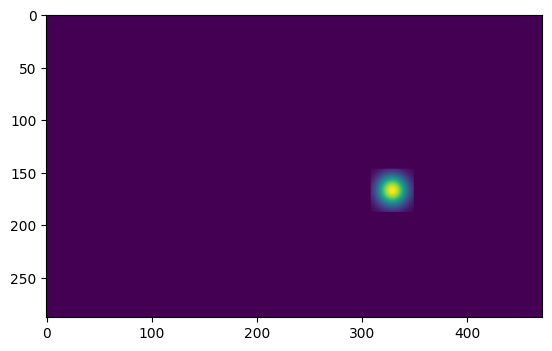

In [9]:
plt.imshow(original_y[0])

# Network Architecture

In [10]:
class ImageAudioNet(nn.Module):

    def __init__(self, input_size, image_width, image_height):
        # torch.set_default_tensor_type(torch.DoubleTensor)
        super().__init__()
        lstm_hidden_size = 512
        num_lstm_lyers = 5
        self.activation = nn.Sigmoid()
        dropout = 0.2
        bidirectional = True
        kernel_size = 7
        upconv_stride = (2, 1)
        dilation = (7, 11)
        upconv_kernel_size = (6, 11)
        output_padding = (3, 3)

        # Audio Net
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=lstm_hidden_size, num_layers=num_lstm_lyers, batch_first=True, bidirectional=bidirectional)
        self.audio_output1 = [nn.Linear(lstm_hidden_size*2 if bidirectional else lstm_hidden_size, 512), self.activation, nn.Dropout(dropout)]
        self.audio_output2 = [nn.Linear(512, 256), self.activation, nn.Dropout(dropout)]
        self.audio_output3 = [nn.Linear(256, 128), nn.Sigmoid()]
        self.audio_output = nn.Sequential(*self.audio_output1, *self.audio_output2, *self.audio_output3)

        # Image Net
        self.conv1 = nn.Conv2d(1, 4, kernel_size)
        self.conv2 = nn.Conv2d(4, 8, kernel_size)
        self.conv3 = nn.Conv2d(8, 1, kernel_size)
        width = self.compute_conv_image_dim(3, kernel_size, 1, 0, image_width)
        height = self.compute_conv_image_dim(3, kernel_size, 1, 0, image_height)
        self.image_output1 = [nn.Linear(int(width*height), 512), self.activation, nn.Dropout(dropout)]
        self.image_output2 = [nn.Linear(512, 256), self.activation, nn.Dropout(dropout)]
        self.image_output3 = [nn.Linear(256, 128), nn.Sigmoid()]
        self.image_output = nn.Sequential(*self.image_output1, *self.image_output2, *self.image_output3)

        # Upconv net
        self.upconv1 = nn.ConvTranspose2d(1, 4, kernel_size=upconv_kernel_size, stride=upconv_stride, dilation=dilation, output_padding=output_padding)
        self.upconv2 = nn.ConvTranspose2d(4, 8, kernel_size=upconv_kernel_size, stride=upconv_stride, dilation=dilation, output_padding=output_padding)
        self.upconv3 = nn.ConvTranspose2d(8, 1, kernel_size=upconv_kernel_size, stride=upconv_stride, dilation=dilation, output_padding=output_padding)
        self.upconv_output = nn.Sequential(self.upconv1, self.upconv2, self.upconv3, nn.Sigmoid())
        # W_out = (W_in −1)×stride[1] + dilation[1]×(kernel_size[1]−1) + 1
        # image_width = (intermediate.shape[1] - 1) * upconv_stride[1] + dilation[1] * (kernel_size - 1) + 1
    
    def forward(self, x1, x2):
        # Audio Net
        x1_out, x1_hidden = self.lstm(x1)
        x1_out = self.audio_output(x1_out)

        # Image Net
        x2_out = self.conv1(x2)
        x2_out = self.conv2(x2_out)
        x2_out = self.conv3(x2_out)
        x2_out = x2_out.view(x2_out.size(0), -1)
        x2_out = self.image_output(x2_out)

        if len(x1_out.shape) == 3:
            x1_out = x1_out.squeeze()
        intermediate_output = torch.vstack((x1_out, x2_out))
        # Tensor of size (N, 2, 128)
        intermediate_output = intermediate_output.reshape(x1_out.shape[0], 1, 2, 128)

        output = self.upconv_output(intermediate_output)
        pad = (3, 2, 7, 6) # pad width by 3 on left and 2 on right, pad height by 7 on top and 6 on bottom
        output = nn.functional.pad(output, pad)
        return output
    
    def compute_conv_image_dim(self, num_convs, kernel_size, stride, padding, input_dim):
        for _ in range(num_convs):
            input_dim = (input_dim - kernel_size + 2*padding)/stride + 1
        return input_dim
    
    def compute_upconv_image_dim(self, num_convs, kernel_size, stride, padding, input_dim):
        for _ in range(num_convs):
            input_dim = (input_dim - 1)*stride - 2*padding + kernel_size - 1
        return input_dim

In [11]:
model = ImageAudioNet(original_x1.shape[2], original_x2.shape[3], original_x2.shape[2])
model(torch.tensor(original_x1)[0:5].to(torch.float32), torch.tensor(original_x2)[0:5].to(torch.float32)).shape

torch.Size([5, 1, 288, 472])

# Training Loop

In [12]:
epochs = 100
optimiser = torch.optim.Adam(model.parameters(), lr=0.0001)
model.to(torch.float32)
model.to(device)
model.train() 
loss_fn = nn.CrossEntropyLoss()
training_loss = []

for epoch in trange(1, epochs + 1):
    total_train_loss = 0
    
    for i in trange(dataset.__len__()):
        x1, x2, y = dataset.__getitem__(i)
        x1, x2, y = torch.tensor(x1).to(torch.float32), torch.tensor(x2).to(torch.float32), torch.tensor(y).to(torch.float32)
        x1, x2, y = x1.to(device), x2.to(device), y.to(device)
        pred = model(x1, x2)
        loss = loss_fn(pred, y)
        loss.backward()
        optimiser.step()
        total_train_loss += loss.item()
        del x1, x2, y, pred
        torch.cuda.empty_cache()
        
    training_loss.append(total_train_loss/len(dataset))

  0%|          | 0/100 [00:00<?, ?it/s]

: 

: 